# Assignment2 - Supervised Learning flow

# Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Joshua 8692
# student 2: Guy 4531

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Loading the Dataset
def load_dataset(file_name):
    df = pd.read_csv(file_name)
    return df

# Loading the datasets and dispalying the first 5 rows of each:

In [3]:
#Loading the files into variables
trainset_filename = 'titanic_train.csv'
testset_filename = 'titanic_test.csv'
trainset = load_dataset(trainset_filename)
testset = load_dataset(testset_filename)
print("The first 5 rows of the Train Set:\n")
print(trainset.head())
print("\n\n")
print("The first 5 rows of the Test Set:\n")
print(testset.head())
print("\n\n")

The first 5 rows of the Train Set:

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       1    0  54.0      1      0  78.2667         1         1
1       2    0  45.0      0      0  13.5000         0         1
2       3    1  20.0      0      0   9.5000         0         0
3       3    1  36.0      0      0   7.8958         0         0
4       3    1  22.0      0      0   8.0500         0         0



The first 5 rows of the Test Set:

   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         0
4       3    1  32.000000      0      0  56.4958         0         1





# Checking the types of variables:

In [4]:
print(trainset.dtypes)
print("\n")
print(testset.dtypes)

Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
Survived      int64
dtype: object


Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
Survived      int64
dtype: object


In [5]:
#Checking for missing values
missing_values = trainset.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


In [6]:
#Checking for duplicated rows
duplicate_rows=trainset[trainset.duplicated()]
print("\n\n")
duplicated_amount = duplicate_rows.shape[0]
if duplicated_amount>0:
    print(f"Found {duplicated_amount} duplicated rows")
    print("Dropping duplicated rows..")
    trainset = trainset.drop_duplicates().reset_index(drop=True)




Found 80 duplicated rows
Dropping duplicated rows..


# Train set - Statistical overlook:

In [7]:
trainset.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.243671,0.618671,29.620597,0.552215,0.422468,34.860904,0.360759,0.419304
std,0.859804,0.486098,13.778271,1.015160,0.835239,52.161783,0.631637,0.493836
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.750000,0.000000,0.000000,8.050000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,16.100000,0.000000,0.000000
75%,3.000000,1.000000,36.000000,1.000000,1.000000,35.500000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


We can see that for example, 75% of people paid $35 or less for a ticket, meaning $515 is a very extreme value. We will probably have to handle some outliers for that feature later.

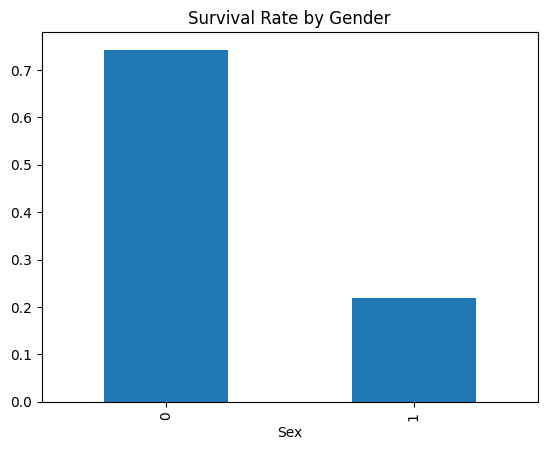

In [8]:
trainset.groupby('Sex')['Survived'].mean().plot(kind='bar',title='Survival Rate by Gender')
plt.show()

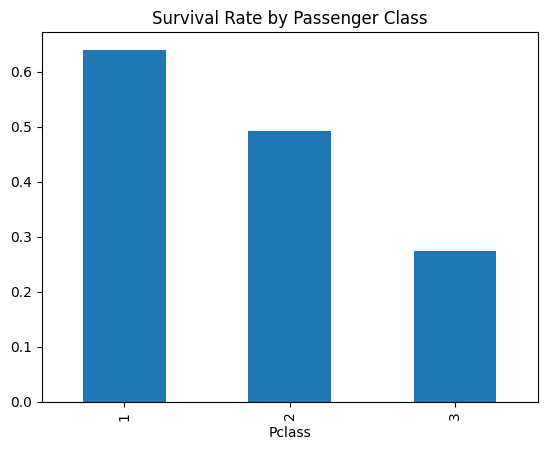

In [9]:
trainset.groupby('Pclass')['Survived'].mean().plot(kind='bar', title='Survival Rate by Passenger Class')
plt.show()

<Axes: xlabel='Survived', ylabel='Fare'>

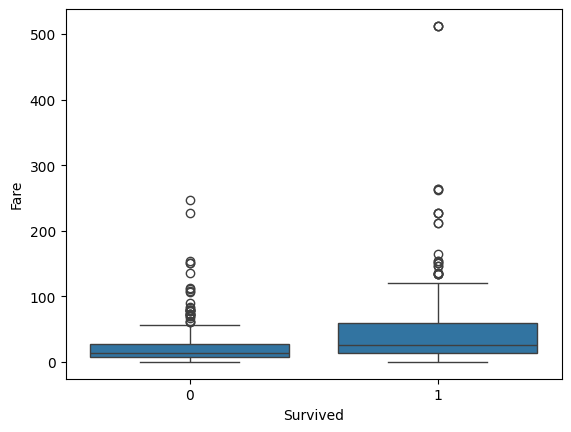

In [10]:
sns.boxplot(x='Survived', y='Fare', data=trainset)


<Axes: xlabel='Survived', ylabel='Fare'>

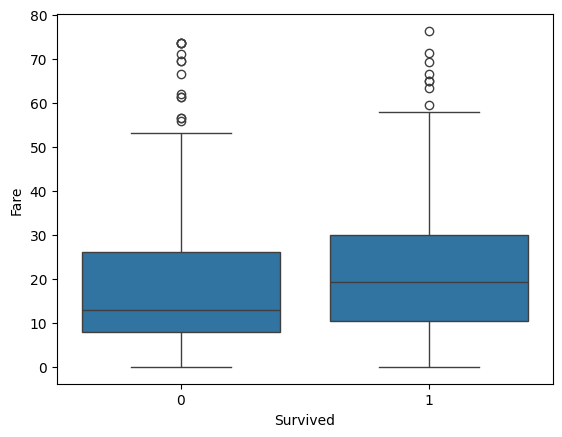

In [11]:
#IQR function as shown in class
def filter_by_IQR(dataframe,feature):
    Q1 = trainset[feature].quantile(0.25)
    Q3 = trainset[feature].quantile(0.75)
    IQR = Q3-Q1
    lower_bound= Q1 - 1.5*IQR
    upper_bound=Q3 + 1.5*IQR
    return dataframe[(trainset[feature]>=lower_bound) & (trainset[feature]<=upper_bound)]
    
#Applying the filter to our dataset
filtered_trainset = filter_by_IQR(trainset,'Fare')
sns.boxplot(x='Survived', y='Fare', data=filtered_trainset)

## Part 3 - Experiments

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score,accuracy_score,classification_report


In [13]:

#Splitting the datasets according to the category we wish to predict
X = filtered_trainset.drop(columns=['Survived'])
Y = filtered_trainset['Survived']
X_test = testset.drop(columns=['Survived'])
Y_test = testset['Survived']

#Used in PCA definition
n_features = X.shape[1]

#Pipeline for the features we will be using
feature_engineering = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('pca',PCA())
    ])

#Models that we will compare
models = {
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

#Used for Gridsearch - Different parameters to see which combination achieves the best F1 score
param_grid = {
    'DecisionTree':{
        'clf__max_depth':[None,10,20],
        'clf__min_samples_split':[2,10,20],
        'features__pca__n_components' : [3,5,n_features],
    },
    'KNN':{
        'clf__n_neighbors':[3,5,7,10],
        'clf__weights':['uniform','distance'],
        'features__pca__n_components': [3,5,n_features]
    }
}

results = []

#Testing each model in our model list with different parameters using GridSearch
for model_name , model in models.items():
    pipeline = Pipeline(steps=[
        ('features', feature_engineering),
        ('clf',model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring=make_scorer(f1_score, average = 'binary'))
    grid_search.fit(X,Y)
    results.append({
        'Model': model_name,
        'Best Parameters': grid_search.best_params_,
        'Best Score': grid_search.best_score_
    })
    print(grid_search.best_params_)
results_df = pd.DataFrame(results)
print(results_df)

{'clf__n_neighbors': 7, 'clf__weights': 'uniform', 'features__pca__n_components': 7}
{'clf__max_depth': 20, 'clf__min_samples_split': 20, 'features__pca__n_components': 7}
          Model                                    Best Parameters  Best Score
0           KNN  {'clf__n_neighbors': 7, 'clf__weights': 'unifo...    0.680634
1  DecisionTree  {'clf__max_depth': 20, 'clf__min_samples_split...    0.644617


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [14]:
#Grabbing the best result from the dataframe we've created
best_result = results_df[results_df['Best Score'] == results_df['Best Score'].max()]
best_model_name = best_result['Model'].values[0]
best_model_params = best_result['Best Parameters'].values[0]
#Creating a pipeline for the features and parameters that give the best F1 score from our previous test, applying the best model
final_pipeline = Pipeline(steps=[
    ('features', feature_engineering),
    ('clf', models[best_model_name])
])
#Setting the best parameters
final_pipeline.set_params(**best_model_params)


Pipeline(steps=[('features',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(n_components=7))])),
                ('clf', KNeighborsClassifier(n_neighbors=7))])

## Part 5 - Apply on test and show model performance estimation

In [15]:
#Applying the steps in the pipeline to our train dataset
final_pipeline.fit(X, Y)

#Applying the model to the test dataset
y_pred_test = final_pipeline.predict(X_test)

#Creating a dataframe to display the performance of the model
results_df=pd.DataFrame(X_test)
results_df['Survived']=y_pred_test
print(results_df.head(5))

#Evaluating the performance of the model
f1 = f1_score(Y_test, y_pred_test, average='binary')
accuracy = accuracy_score(Y_test, y_pred_test)
print(f"F1 Score on test set: {f1}")
print(f"Accuracy on test set: {accuracy}")

#Classification report on the model for additional insight
print(classification_report(Y_test, y_pred_test))


   Pclass  Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3    1  35.000000      0      0   7.0500         0         0
1       3    1  30.000000      0      0   7.2500         0         0
2       3    1  29.699118      0      0  14.5000         0         0
3       3    0  21.000000      0      0   7.7500         2         1
4       3    1  32.000000      0      0  56.4958         0         0
F1 Score on test set: 0.7521367521367521
Accuracy on test set: 0.8379888268156425
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       118
           1       0.79      0.72      0.75        61

    accuracy                           0.84       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.84      0.84      0.84       179

